In [1]:
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import emoji
import string 
# Tokenization: split sentences into words, lowercase the words, remove punctuation
import spacy
from spacy.tokenizer import Tokenizer
import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from wordcloud import STOPWORDS
import pyLDAvis.gensim_models
import pyLDAvis
import seaborn as sns


stopwords = set(STOPWORDS)
import sys
sys.path.insert(1, "C:\\Users\\ollie\\anaconda3\\Lib\\site-packages\\en_core_web_lg-3.0.0-py3.9.egg")
import en_core_web_lg
nlp = spacy.load('en_core_web_lg') # Load english version of spaCy


plt.style.use('fivethirtyeight')

In [2]:
 # Variables that contain user credentials to access Twitter API

API_Key = "yQYG1NxWXVJzFMGzYLPUAyKCe"
API_Key_Secret = "epUQTwaCkIkKENvJw5LpcgPk8cuS54tqHQCrlGiA3mzLvrpIgP" 
Access_Token = "1415883671685398530-1FwkU7DMkYfLXyJ1tUGpZoi2te8aKr"
Access_Token_Secret = "QoLDp1nnWT5hiHuUjH118ZaQ9Ja4AWbjhl4uj9Larq5I5"

# # Create the authentification object
# authenticate = tweepy.OAuthHandler(API_Key, API_Key_Secret)

# # Set the access token
# authenticate.set_access_token(Bearer_Token)

# # Create the API object while passing in the auth information
# api = tweepy.API(authenticate, wait_on_rate_limit = True)

authenticate = tweepy.OAuthHandler(API_Key, API_Key_Secret)

authenticate.set_access_token(Access_Token, Access_Token_Secret)

# Create the API object while in the auth information
api = tweepy.API(authenticate, wait_on_rate_limit = True)

C:\Users\ollie\anaconda3\lib\site-packages\tweepy\auth.py:120: DeprecationWarning: OAuthHandler is deprecated; use OAuth1UserHandler instead.
  warnings.warn(


In [3]:
# Extract 100 tweets from the twitter user
posts = api.user_timeline(screen_name="altai_kh", count = 300)

# Print the last 5 tweets from the account
for tweet in posts[0:5]:
    print(tweet.text+'\n')

RT @Tuuguu67622493: Энэ одоо хэн гээч хувалз нь эмнэлгийн газраас аваад юу ч хийхгүй ингэж олон жил болоод бна вэ?АТГ шалгах л эд биш үү? 2…

RT @zorig316: ТЕГ: НӨАТ-ын буцаан олголтоор улирал бүр тэрбум ₮ хууль бусаар авч байсан бүлэг этгээдүүдийг илрүүлэн шалгаж байна ‼️‼️‼️
Тэд…

@Undqk Ёоёо хахаха

RT @Tsetseg01: Би гудамжинд сэндвич хийж зармаар байна. Бас халуун кофе, натурал жимсний жүүс блэндэрдээд зармаар байна. Болохым уу? 🤔Хэлээ…

RT @batengineer: Эрдэнэтийн овоолгыг иргэдэд өгөхөд хамгийн ихээр эрх ашиг нь хөндөгдөх этгээд хэнб? Ачит их гэдэг луйврын компани мөн үү.…



In [5]:
# Create a dataframe with a column called Tweets
df = pd.DataFrame([tweet.text for tweet in posts], columns=['Tweets'])

df.head()

,Tweets
0,RT @Ironman_mn: Монгол Улсын хүн ам яг одоо 3....
1,RT @batdorj911: МАН л нохойндоо тавих ёстой юм...
2,RT @Sarnai_Sa: Үйлийн үрээр Монголчууд чамтай ...
3,"RT @nomsymomsy: Ёо, Номин супермаркет арай дэн..."
4,RT @erdene457: Бүтэн 6 жил үнэмлэхүй эрх барьч...


In [76]:
# Clean the text

# Create a function to clean the tweets
def cleanTxt(text):
    # Substitute certain patterns in the tweets
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #removes @mentions
    text = re.sub(r'#', '', text) #Removing the # symbol
    text = re.sub(r'RT[\s]+', '', text) #Removing RT
    text = re.sub(r'https?:\/\/\S+', '', text) #Will remove the hyperlinks
    return text

# Cleaning the text
df['Tweets'] = df['Tweets'].apply(cleanTxt)

In [77]:
# Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Create two new columns
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

df

,Tweets,Subjectivity,Polarity
0,_mn: Монгол Улсын хүн ам яг одоо 3.434.783 бол...,0.0,0.0
1,: МАН л нохойндоо тавих ёстой юмаа тавьсан юм ...,0.0,0.0
2,_Sa: Үйлийн үрээр Монголчууд чамтай зууралдаж ...,0.0,0.0
3,": Ёо, Номин супермаркет арай дэндүү бүдүүлэг ү...",0.0,0.0
4,: Бүтэн 6 жил үнэмлэхүй эрх барьчихаад АН-тай ...,0.0,0.0
...,...,...,...
190,: Та Монгол Улсын хэд дэх иргэн бэ? Регистрийн...,0.0,0.0
191,: Энэ бид хоёр паралель ертөнцөд л амьдраад ба...,0.0,0.0
192,: Багадаа тоо бодож бодож байгаад шууд инженер...,0.0,0.0
193,": гуйя, манайхаан🙏Яарах шалтгаан бна! Хөгжлийн...",0.0,0.0


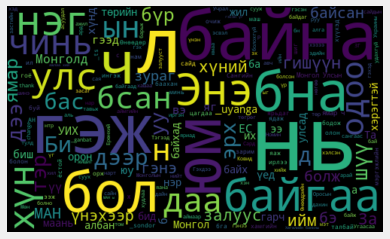

In [78]:
# Plot the word cloud
allWords = ' '.join([tweets for tweets in df['Tweets']])
wordCloud = WordCloud(width = 500, height=300, random_state = 21, max_font_size = 119).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Create a function to compare the negative, neutral and positive analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
df['Analysis'] = df['Polarity'].apply(getAnalysis)

# Show the dataframe
df

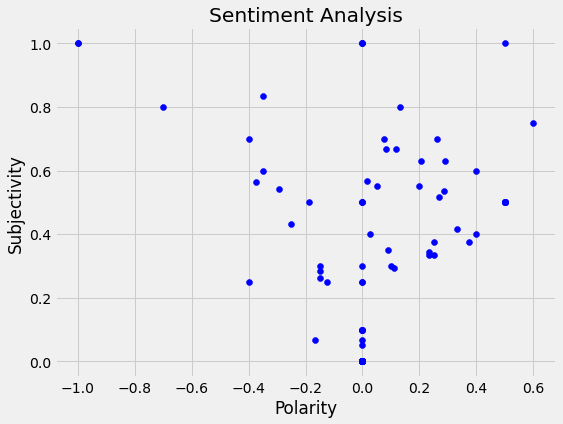

In [43]:
# Plot the polarty and subjectivity
plt.figure(figsize = (8, 6))
for i in range(0, df.shape[0]):
    plt.scatter(df['Polarity'][i], df['Subjectivity'][i], color = 'Blue')

plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [6]:
# Get the percentage of positive tweets
ptweets = df[df.Analysis == 'Positive']
ptweets = ptweets['Tweets']

ptweets

AttributeError: 'DataFrame' object has no attribute 'Analysis'

## Get the data

In [4]:
 # Variables that contain user credentials to access Twitter API

API_Key = "yQYG1NxWXVJzFMGzYLPUAyKCe"
API_Key_Secret = "epUQTwaCkIkKENvJw5LpcgPk8cuS54tqHQCrlGiA3mzLvrpIgP" 
Access_Token = "1415883671685398530-1FwkU7DMkYfLXyJ1tUGpZoi2te8aKr"
Access_Token_Secret = "QoLDp1nnWT5hiHuUjH118ZaQ9Ja4AWbjhl4uj9Larq5I5"

# # Create the authentification object
# authenticate = tweepy.OAuthHandler(API_Key, API_Key_Secret)

# # Set the access token
# authenticate.set_access_token(Bearer_Token)

# # Create the API object while passing in the auth information
# api = tweepy.API(authenticate, wait_on_rate_limit = True)

authenticate = tweepy.OAuthHandler(API_Key, API_Key_Secret)

authenticate.set_access_token(Access_Token, Access_Token_Secret)

# Create the API object while in the auth information
api = tweepy.API(authenticate, wait_on_rate_limit = True)

C:\Users\ollie\anaconda3\lib\site-packages\tweepy\auth.py:120: DeprecationWarning: OAuthHandler is deprecated; use OAuth1UserHandler instead.
  warnings.warn(


In [5]:
import base64
import requests
# returns a bearer_header to attach to requests to the Twitter api v2 enpoints which are 
# not yet supported by tweepy 
def get_bearer_header():
    API_Key = "yQYG1NxWXVJzFMGzYLPUAyKCe"
    API_Key_Secret = "epUQTwaCkIkKENvJw5LpcgPk8cuS54tqHQCrlGiA3mzLvrpIgP" 
    Access_Token = "1415883671685398530-1FwkU7DMkYfLXyJ1tUGpZoi2te8aKr"
    Access_Token_Secret = "QoLDp1nnWT5hiHuUjH118ZaQ9Ja4AWbjhl4uj9Larq5I5"
    bearer_token = "AAAAAAAAAAAAAAAAAAAAAHrEbQEAAAAAeEN3uxEiSGEnxvCwGhOZCSDj%2Fe0%3DWddtocQJEsg65lAZeVzvn6IW7sZDOBbMKk50CplYpzdVZyjpQl"
    bearer_header = {
       'Accept-Encoding': 'gzip',
       'Authorization': 'Bearer {}'.format(bearer_token),
       'oauth_consumer_key': API_Key
       }
    return bearer_header

def makeTwitterQuery(query, fields, amount):
    uri = 'https://api.twitter.com/2/tweets/search/recent?'
    params = {'query': query,
       'tweet.fields': fields,
        'max_results':str(amount)
        #'tweet.fields':'replies'
       }
    bearer_header = get_bearer_header()
    resp = requests.get(uri, headers=bearer_header, params=params)
    return resp.json()

def getTweets(account_name, amount):
    query = f'from:{account_name}'
    gett = makeTwitterQuery(query, 'text,conversation_id', amount)
    return gett

def getConversation(conversation_id, amount):
    query = f'conversation_id:{conversation_id}'
    gett = makeTwitterQuery(query, 'text,conversation_id',amount)
    return gett

data = getTweets('jordanbpeterson', 50)
print(len(data['data']))
conversations = []
for datum in data['data']:
    conversations.append(getConversation(datum['conversation_id'], 50))

19


In [14]:
for conversation in conversations:
    if 'data' in conversation:
        pass
    else:
        conversation['data'] = []

df = pd.DataFrame([datum['text'] for datum in data['data']], columns=['RawTweet'])
df['TweetText'] = df['RawTweet']
df['RawReplies'] = df['RawTweet']
df['ReplyObjects'] = df['RawTweet']

df['TweetText'] = [datum['text'] for datum in data['data']]
df['RawReplies'] = [conversation['data'] for conversation in conversations]

df
# df['Raw text'] = df['Raw tweets'].apply(lambda tweet: tweet.full_text)
# df['Raw retweets'] = df['Raw tweets'].apply(lambda tweet: Retweets(tweet))

,RawTweet,TweetText,RawReplies,ReplyObjects
0,Treasures of art and intellect should be an in...,Treasures of art and intellect should be an in...,"[{'conversation_id': '1519642531612528646', 'i...",Treasures of art and intellect should be an in...
1,"The more people sort themselves out, the more ...","The more people sort themselves out, the more ...","[{'conversation_id': '1519396778067517441', 'i...","The more people sort themselves out, the more ..."
2,A plan is better than no plan.\n\nFrom the Bri...,A plan is better than no plan.\n\nFrom the Bri...,"[{'conversation_id': '1519336770952998913', 'i...",A plan is better than no plan.\n\nFrom the Bri...
3,Posting on Parler - https://t.co/GdTSBLipaw,Posting on Parler - https://t.co/GdTSBLipaw,"[{'conversation_id': '1518991673984012288', 'i...",Posting on Parler - https://t.co/GdTSBLipaw
4,"You may think, “I can’t give them up.” Not onl...","You may think, “I can’t give them up.” Not onl...","[{'conversation_id': '1518988117361020930', 'i...","You may think, “I can’t give them up.” Not onl..."
5,"If you’re trying to get your life together, an...","If you’re trying to get your life together, an...","[{'conversation_id': '1518988117361020930', 'i...","If you’re trying to get your life together, an..."
6,But a friend is also someone you can tell good...,But a friend is also someone you can tell good...,"[{'conversation_id': '1518988117361020930', 'i...",But a friend is also someone you can tell good...
7,A friend is someone you can tell bad news to.\...,A friend is someone you can tell bad news to.\...,"[{'conversation_id': '1518988117361020930', 'i...",A friend is someone you can tell bad news to.\...
8,"In this episode, @DouglasKMurray and I discuss...","In this episode, @DouglasKMurray and I discuss...","[{'conversation_id': '1518640334175092736', 'i...","In this episode, @DouglasKMurray and I discuss..."
9,"It's hard to tell the truth, the full truth. ⁣...","It's hard to tell the truth, the full truth. ⁣...","[{'conversation_id': '1518636452766224387', 'i...","It's hard to tell the truth, the full truth. ⁣..."


In [20]:
class DynReplies():
    pass

def getDynamicReplies(conversation):
    # Make dynamic retweeT
    dynReplies = DynReplies()
    dynReplies.rawTextsList = []
    if (conversation['data'] is not None):
        for x in conversation['data']:
            textie = x['text']
            dynReplies.rawTextsList.append(x['text'])
    else:
        dynReplies.rawTextList = None
    return dynReplies
df['ReplyObjects'] = [getDynamicReplies(conversation) for conversation in conversations]

In [21]:
df['ReplyObjects'][0].rawTextsList

['@BenJTavsfan @jordanbpeterson @RalstonCollege By the way. Your tweet was tagged sensitive content?  How? I’m not seeing it.',
 '@BenJTavsfan @jordanbpeterson @RalstonCollege Hmm a comment about an MA in one year because it’s not an “accredited college”. That’s kinda like saying because I’m not a Dr. I somehow can’t understand anything about medicine. Might be a great program. Also, probably is a BA &gt; MA course. Doubtful it’s 0-60 &amp; poof.',
 '@jordanbpeterson @RalstonCollege Oh the humanities…',
 '@jordanbpeterson @RalstonCollege That inheritance includes cultivating young minds to receive it',
 '@jordanbpeterson @RalstonCollege Hmm a MA in one year? Non accredited college?']

## <span style="background-color: #FFFF00">Please don't click on cell above unless absolutely necessary - it will run for 30 minutes at least!</span>

### Creating dynamic object

In [25]:
def applyToReplyObj(newField, function, fromAttr, wrapAsList):
    for atRow in range(0, len(df['ReplyObjects'])):
        replyObjects = df['ReplyObjects'][atRow] #n-th row
        if wrapAsList == True:
            originalList = getattr(df['ReplyObjects'][atRow], fromAttr)
            value = wrapperForLists(originalList, function)
        else:
            value = function(getattr(df['ReplyObjects'][atRow], fromAttr))
        setattr(df['ReplyObjects'][atRow], newField, value)

# Will apply functionForSignle to members of originalList, and return a similar array
def wrapperForLists(originalList, functionForSingle):
    newList = []
    for x in originalList:
        y = functionForSingle(x)
        newList.append(y)
    return newList

In [152]:
df['ConversationObjects'][3].
print(df['Raw retweets'][2].

Status(_api=<tweepy.api.API object at 0x0000017670461340>, _json={'created_at': 'Thu Apr 14 00:10:50 +0000 2022', 'id': 1514395719939104771, 'id_str': '1514395719939104771', 'text': 'RT @jordanbpeterson: They both have orange hair (except @PierrePoilievre )!', 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'jordanbpeterson', 'name': 'Dr Jordan B Peterson', 'id': 95092020, 'id_str': '95092020', 'indices': [3, 19]}, {'screen_name': 'PierrePoilievre', 'name': 'Pierre Poilievre', 'id': 242827267, 'id_str': '242827267', 'indices': [56, 72]}], 'urls': []}, 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 34119879, 'id_str': '34119879', 'name': 'RedEyedVinithian', 'screen_name': 'Vinithian', 'location': '', 'description':

## Deleting emojis, etc. (for the retweets to the first tweet)

In [31]:
# Create a function to clean the tweets
def deleteSpecialSymbols(text):
    # Substitute certain patterns in the tweets
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #removes @mentions
    text = re.sub(r'#', '', text) #Removing the # symbol
    text = re.sub(r'RT[\s]+', '', text) #Removing RT
    text = re.sub(r'https?:\/\/\S+', '', text) #Will remove the hyperlinks
    
    return text

def give_emoji_free_text(text):
    """
    Removes emoji's from tweets
    Accepts:
        Text (tweets)
    Returns:
        Text (emoji free tweets)
    """
    emoji_list = [c for c in text if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def url_free_text(text):
    '''
    Cleans text from urls
    '''
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'https\S+', '', text)
    return text

def getCleanText(text):
    text = deleteSpecialSymbols(text)
    text = give_emoji_free_text(text)
    text = url_free_text(text)
    return text

# Cleaning the text of tweets
df['cleanedTweet'] = df['RawTweet'].apply(getCleanText)


# Cleaning the retweets
applyToReplyObj('cleanedTextsList', getCleanText, 'rawTextsList', True)

### Get the subjectivity data

In [29]:
print(df['ReplyObjects'][0].rawTextsList)
#[item for sublist in t for item in sublist]
print(df['ReplyObjects'][0].cleanedTextsList)
#[item for sublist in t for item in sublist]

['@BenJTavsfan @jordanbpeterson @RalstonCollege By the way. Your tweet was tagged sensitive content?  How? I’m not seeing it.', '@BenJTavsfan @jordanbpeterson @RalstonCollege Hmm a comment about an MA in one year because it’s not an “accredited college”. That’s kinda like saying because I’m not a Dr. I somehow can’t understand anything about medicine. Might be a great program. Also, probably is a BA &gt; MA course. Doubtful it’s 0-60 &amp; poof.', '@jordanbpeterson @RalstonCollege Oh the humanities…', '@jordanbpeterson @RalstonCollege That inheritance includes cultivating young minds to receive it', '@jordanbpeterson @RalstonCollege Hmm a MA in one year? Non accredited college?']
['By the way. Your tweet was tagged sensitive content? How? I’m not seeing it.', 'Hmm a comment about an MA in one year because it’s not an “accredited college”. That’s kinda like saying because I’m not a Dr. I somehow can’t understand anything about medicine. Might be a great program. Also, probably is a BA &

In [33]:
# Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Create two new columns
df['Subjectivity'] = df['cleanedTweet'].apply(getSubjectivity)
df['Polarity'] = df['cleanedTweet'].apply(getPolarity)


# applyToRetweetAs('Subjectivity', getSubjectivity, 'cleanedText')
# applyToRetweetAs('Polarity', getPolarity, 'cleanedText')

applyToReplyObj('SubjectivityList', getSubjectivity, 'cleanedTextsList', True)
applyToReplyObj('PolarityList', getPolarity, 'cleanedTextsList', True)

### Tokenization

In [35]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)


# Custom stopwords
custom_stopwords = ['hi','\n','\n\n', '&amp;', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)



def tokenize(dfColumn):
    tokens = []

#     tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
#     #tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
#     tokens = re.sub('@*!*\$*', '', tokens) # Remove @ ! $
#     tokens = tokens.strip(',') # TESTING THIS LINE
#     tokens = tokens.strip('?') # TESTING THIS LINE
#     tokens = tokens.strip('!') # TESTING THIS LINE
#     tokens = tokens.strip("'") # TESTING THIS LINE
#     tokens = tokens.strip(".") # TESTING THIS LINE
    if isinstance(dfColumn, str):
        doc_tokens = []
        tokens = tokenizer(dfColumn) 
        for token in tokens:
            if token.text.lower() not in STOP_WORDS:
                doc_tokens.append(token.text.lower())   
        return (doc_tokens)
    else:
        for doc in tokenizer.pipe(dfColumn, batch_size=500):
            doc_tokens = []    
            for token in doc: 
                if token.text.lower() not in STOP_WORDS:
                    doc_tokens.append(token.text.lower())   
            tokens.append(doc_tokens)
        return tokens

#Tokenize the tweets
df['tokens'] = tokenize(df['cleanedTweet'])

# Cleaning the retweets
# applyToRetweetAs('tokens', tokenize, 'cleanedText')
applyToReplyObj('tokensList', tokenize, 'cleanedTextsList', True)

In [36]:
df

,RawTweet,TweetText,RawReplies,ReplyObjects,cleanedTweet,Subjectivity,Polarity,tokens
0,Treasures of art and intellect should be an in...,Treasures of art and intellect should be an in...,"[{'conversation_id': '1519642531612528646', 'i...",<__main__.DynReplies object at 0x00000187BCEF5...,Treasures of art and intellect should be an in...,0.250000,0.250000,"[treasures, art, intellect, inheritance, every..."
1,"The more people sort themselves out, the more ...","The more people sort themselves out, the more ...","[{'conversation_id': '1519396778067517441', 'i...",<__main__.DynReplies object at 0x00000187BCEF5...,"The more people sort themselves out, the more ...",0.406250,0.375000,"[people, sort, out,, responsibility, world, pr..."
2,A plan is better than no plan.\n\nFrom the Bri...,A plan is better than no plan.\n\nFrom the Bri...,"[{'conversation_id': '1519336770952998913', 'i...",<__main__.DynReplies object at 0x00000187BCEF5...,A plan is better than no plan. From the Brisba...,0.500000,0.500000,"[plan, better, plan., brisbane, 12, rules, lif..."
3,Posting on Parler - https://t.co/GdTSBLipaw,Posting on Parler - https://t.co/GdTSBLipaw,"[{'conversation_id': '1518991673984012288', 'i...",<__main__.DynReplies object at 0x00000187BCEF5...,Posting on Parler -,0.000000,0.000000,"[posting, parler]"
4,"You may think, “I can’t give them up.” Not onl...","You may think, “I can’t give them up.” Not onl...","[{'conversation_id': '1518988117361020930', 'i...",<__main__.DynReplies object at 0x00000187BD1F4...,"You may think, “I can’t give them up.” Not onl...",0.549887,0.257596,"[think,, “i, can’t, up.”, you,, better, them.,..."
5,"If you’re trying to get your life together, an...","If you’re trying to get your life together, an...","[{'conversation_id': '1518988117361020930', 'i...",<__main__.DynReplies object at 0x00000187BD1F4...,"If you’re trying to get your life together, an...",0.150000,0.250000,"[you’re, trying, life, together,, friends, way..."
6,But a friend is also someone you can tell good...,But a friend is also someone you can tell good...,"[{'conversation_id': '1518988117361020930', 'i...",<__main__.DynReplies object at 0x00000187BD1F4...,But a friend is also someone you can tell good...,0.635714,0.546429,"[friend, tell, good, news, to., say,, “wow!, v..."
7,A friend is someone you can tell bad news to.\...,A friend is someone you can tell bad news to.\...,"[{'conversation_id': '1518988117361020930', 'i...",<__main__.DynReplies object at 0x00000187BD1F4...,A friend is someone you can tell bad news to. ...,0.688889,-0.633333,"[friend, tell, bad, news, to., won’t, tell, yo..."
8,"In this episode, @DouglasKMurray and I discuss...","In this episode, @DouglasKMurray and I discuss...","[{'conversation_id': '1518640334175092736', 'i...",<__main__.DynReplies object at 0x00000187BD1F4...,"In this episode, and I discuss the current ass...",0.400000,0.000000,"[episode,, discuss, current, assault, west,, s..."
9,"It's hard to tell the truth, the full truth. ⁣...","It's hard to tell the truth, the full truth. ⁣...","[{'conversation_id': '1518636452766224387', 'i...",<__main__.DynReplies object at 0x00000187BD1F4...,"It's hard to tell the truth, the full truth. ⁣...",0.545833,0.029167,"[hard, tell, truth,, truth., ⁣, ⁣, sydney, 12,..."


### Lemmatization
Convert "Studying" into "Study", "Meeting" into "meet", "better" and "best" into "good"

In [37]:
# Make tokens a string again
df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df['tokens']]


def toString(tokens):
    return ' '.join(tokens)
    
applyToReplyObj('tokens_back_to_textList', toString, 'tokensList', True)

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df['lemmas'] = df['tokens_back_to_text'].apply(get_lemmas)
applyToReplyObj('lemmasList', get_lemmas, 'tokens_back_to_textList', True)

In [109]:
print(df['RetweetObjects'][0][6].cleanedText)
##print(df['lemma_tokens_extended'][3])

: "a new study"


In [41]:
# Make lemmas a string again
df['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in df['lemmas']]
applyToReplyObj('lemmas_back_to_textList', toString, 'lemmasList', True)
# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #removes @mentions
    text = re.sub(r'#', '', text) #Removing the # symbol
    text = re.sub(r'rt[\s]+', '', text) #Removing RT
    text = re.sub(r'https?:\/\/\S+', '', text) #Will remove the hyperlinks
    
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    #tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', tokens) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
df['lemma_tokens'] = df['lemmas_back_to_text'].apply(tokenize)
applyToReplyObj('lemma_tokensList', tokenize, 'lemmas_back_to_textList', True)
# applyToRetweetAs('lemma_tokens', tokenize, 'lemmas_back_to_text')

<>:22: DeprecationWarning: invalid escape sequence \$
<>:22: DeprecationWarning: invalid escape sequence \$
C:\Users\ollie\AppData\Local\Temp/ipykernel_14944/926740945.py:22: DeprecationWarning: invalid escape sequence \$
  tokens = re.sub('@*!*\$*', '', tokens) # Remove @ ! $


In [42]:
df

,RawTweet,TweetText,RawReplies,ReplyObjects,cleanedTweet,Subjectivity,Polarity,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens
0,Treasures of art and intellect should be an in...,Treasures of art and intellect should be an in...,"[{'conversation_id': '1519642531612528646', 'i...",<__main__.DynReplies object at 0x00000187BCEF5...,Treasures of art and intellect should be an in...,0.250000,0.250000,"[treasures, art, intellect, inheritance, every...",treasures art intellect inheritance everyone. ...,"[treasure, art, intellect, inheritance, exactl...",treasure art intellect inheritance exactly see...,"[treasure, aintellect, inheritance, exactly, s..."
1,"The more people sort themselves out, the more ...","The more people sort themselves out, the more ...","[{'conversation_id': '1519396778067517441', 'i...",<__main__.DynReplies object at 0x00000187BCEF5...,"The more people sort themselves out, the more ...",0.406250,0.375000,"[people, sort, out,, responsibility, world, pr...","people sort out, responsibility world problems...","[people, sort, responsibility, world, problem,...",people sort responsibility world problem solve...,"[people, soresponsibility, world, problem, sol..."
2,A plan is better than no plan.\n\nFrom the Bri...,A plan is better than no plan.\n\nFrom the Bri...,"[{'conversation_id': '1519336770952998913', 'i...",<__main__.DynReplies object at 0x00000187BCEF5...,A plan is better than no plan. From the Brisba...,0.500000,0.500000,"[plan, better, plan., brisbane, 12, rules, lif...",plan better plan. brisbane 12 rules life tour.,"[plan, well, plan, brisbane, 12, rule, life, t...",plan well plan brisbane 12 rule life tour,"[plan, well, plan, brisbane, 12, rule, life, t..."
3,Posting on Parler - https://t.co/GdTSBLipaw,Posting on Parler - https://t.co/GdTSBLipaw,"[{'conversation_id': '1518991673984012288', 'i...",<__main__.DynReplies object at 0x00000187BCEF5...,Posting on Parler -,0.000000,0.000000,"[posting, parler]",posting parler,"[post, parler]",post parler,"[post, parler]"
4,"You may think, “I can’t give them up.” Not onl...","You may think, “I can’t give them up.” Not onl...","[{'conversation_id': '1518988117361020930', 'i...",<__main__.DynReplies object at 0x00000187BD1F4...,"You may think, “I can’t give them up.” Not onl...",0.549887,0.257596,"[think,, “i, can’t, up.”, you,, better, them.,...","think, “i can’t up.” you, better them. they’re...","[think, well, aim, go, good, happen, certainly...",think well aim go good happen certainly good 4/4,"[think, well, aim, go, good, happen, certainly..."
5,"If you’re trying to get your life together, an...","If you’re trying to get your life together, an...","[{'conversation_id': '1518988117361020930', 'i...",<__main__.DynReplies object at 0x00000187BD1F4...,"If you’re trying to get your life together, an...",0.150000,0.250000,"[you’re, trying, life, together,, friends, way...","you’re trying life together, friends way, that...","[try, life, friend, way, actually, useful, ide...",try life friend way actually useful identify r...,"[try, life, friend, way, actually, useful, ide..."
6,But a friend is also someone you can tell good...,But a friend is also someone you can tell good...,"[{'conversation_id': '1518988117361020930', 'i...",<__main__.DynReplies object at 0x00000187BD1F4...,But a friend is also someone you can tell good...,0.635714,0.546429,"[friend, tell, good, news, to., say,, “wow!, v...","friend tell good news to. say, “wow! vale tear...","[friend, tell, good, news, wow, vale, tear, go...",friend tell good news wow vale tear good happe...,"[friend, tell, good, news, wow, vale, tear, go..."
7,A friend is someone you can tell bad news to.\...,A friend is someone you can tell bad news to.\...,"[{'conversation_id': '1518988117361020930', 'i...",<__main__.DynReplies object at 0x00000187BD1F4...,A friend is someone you can tell bad news to. ...,0.688889,-0.633333,"[friend, tell, bad, news, to., won’t, tell, yo...",friend tell bad news to. won’t tell 

### Topic Modeling (Linear Discriminant Analysis)

In [72]:
df['lemma_tokens_extended'] = df['ReplyObjects']
for i in range(0, len(df['ReplyObjects'])):
    lemma_tokensList = df['ReplyObjects'][i].lemma_tokensList
    subjectivityList = df['ReplyObjects'][i].SubjectivityList
    polarityList = df['ReplyObjects'][i].PolarityList
    
    temporaryList = []
    subjectivityList = []
    polarityList = []
    for z in df['lemma_tokens'][i]:
        temporaryList.append(z)

    for y in lemma_tokensList:
        for x in y:
            temporaryList.append(x)
    df['lemma_tokens_extended'][i] = temporaryList

print(df['lemma_tokens_extended'])

0     [treasure, aintellect, inheritance, exactly, s...
1     [people, soresponsibility, world, problem, sol...
2     [plan, well, plan, brisbane, 12, rule, life, t...
3     [post, parler, jordon, need, cash, jp, leave, ...
4     [think, well, aim, go, good, happen, certainly...
5     [try, life, friend, way, actually, useful, ide...
6     [friend, tell, good, news, wow, vale, tear, go...
7     [friend, tell, bad, news, wo, tell, idiot, wo,...
8     [episode, discuss, current, assault, west, sla...
9     [hard, tell, truth, truth, ⁣, ⁣, sydney, 12, r...
10    [guideline, document, faculty, behaviour, moun...
11    [connection, consciousness, regret, dare, beli...
12    [postmodernism, sleight, hand, identity, polit...
13    [fit, tux, youtuber, leader, young, man, tailo...
14    [new, column, rex, murphy, colour, code, canad...
15    [find, post, parler, oh, ok, chance, 2, show, ...
16    [fool, master, willing, fool, master, great, r...
17    [trait, neuroticism, woman, small, cost, s

C:\Users\ollie\AppData\Local\Temp/ipykernel_14944/992271672.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemma_tokens_extended'][i] = temporaryList


In [73]:
# Create a id2word dictionary
id2word = Dictionary(df['lemma_tokens_extended'])
print((id2word))


# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))


# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in df['lemma_tokens_extended']]


# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=5)


# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]


# Create Topics
topics = [' '.join(t[0:10]) for t in words]


# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

Dictionary(2841 unique tokens: ['0', '60', 'accredit', 'aintellect', 'apply']...)
969
------ Topic 0 ------
truth know think people peterson life say good mean cancel

------ Topic 1 ------
friend l know good need people thing tell feel say

------ Topic 2 ------
child believe marriage watch peterson know people way speech point

------ Topic 3 ------
friend l plan need good know thing think help feel

------ Topic 4 ------
look man jordan peterson right good cancel twitter love jp



In [102]:
df

,Raw tweets,Raw text,Raw retweets,RetweetObjects,cleanedText,Subjectivity,Polarity,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens,lemma_tokens_extended
0,Status(_api=<tweepy.api.API object at 0x000001...,"""a new study"" https://t.co/jslyV0HTey",<__main__.Retweets object at 0x0000017670423700>,[<__main__.DynRetweet object at 0x000001764FAA...,"""a new study""",0.454545,0.136364,"[""a, new, study""]","""a new study""","[new, study]",new study,"[new, study, new, study, new, study, new, stud...","[new, study, new, study, new, study, new, stud..."
1,Status(_api=<tweepy.api.API object at 0x000001...,"RT @bdomenech: Democrats, I have terrible news...",<__main__.Retweets object at 0x00000176411C89A0>,[],": Democrats, I have terrible news for you. His...",1.000000,-1.000000,"[:, democrats,, terrible, news, you., hispanic...",": democrats, terrible news you. hispanics repu...","[democrat, terrible, news, hispanic, republica...",democrat terrible news hispanic republican min...,"[democrat, terrible, news, hispanic, republica...","[democrat, terrible, news, hispanic, republica..."
2,Status(_api=<tweepy.api.API object at 0x000001...,They both have orange hair (except @PierrePoil...,<__main__.Retweets object at 0x000001767CC2A910>,[<__main__.DynRetweet object at 0x000001764FC2...,They both have orange hair (except )!,0.000000,0.000000,"[orange, hair, (except, )!]",orange hair (except )!,"[orange, hair]",orange hair,"[orange, hair, orange, hair, orange, hair, ora...","[orange, hair, orange, hair, orange, hair, ora..."
3,Status(_api=<tweepy.api.API object at 0x000001...,Societies that actively devalue motherhood hav...,<__main__.Retweets object at 0x000001764151EDC0>,[<__main__.DynRetweet object at 0x000001764FC2...,Societies that actively devalue motherhood hav...,0.800000,-0.316667,"[societies, actively, devalue, motherhood, irr...",societies actively devalue motherhood irredeem...,"[society, actively, devalue, motherhood, irred...",society actively devalue motherhood irredeemab...,"[society, actively, devalue, motherhood, irred...","[society, actively, devalue, motherhood, irred..."
4,Status(_api=<tweepy.api.API object at 0x000001...,"""help Canadians"" https://t.co/j1e95kf0TG",<__main__.Retweets object at 0x0000017641637970>,[<__main__.DynRetweet object at 0x000001764FA4...,"""help Canadians""",0.000000,0.000000,"[""help, canadians""]","""help canadians""","[help, canadian]",help canadian,"[help, canadian, help, canadian, help, canadia...","[help, canadian, help, canadian, help, canadia..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,Status(_api=<tweepy.api.API object at 0x000001...,And that's a historic moment.,<__main__.Retweets object at 0x000001764E56AFD0>,[<__main__.DynRetweet object at 0x000001764FC8...,And that's a historic moment.,0.000000,0.000000,"[that's, historic, moment.]",that's historic moment.,"[historic, moment]",historic moment,"[historic, moment, historic, moment, historic,...","[historic, moment, historic, moment, historic,..."
216,Status(_api=<tweepy.api.API object at 0x000001...,I don't know what a woman is either but appare...,<__main__.Retweets object at 0x000001764F668310>,[<__main__.DynRetweet object at 0x000001764FC8...,I don't know what a woman is either but appare...,0.350000,0.050000,"[don't, know, woman, apparently, appointed, su...",don't know woman apparently appointed supreme ...,"[know, woman, apparently, appoint, supreme, co...",know woman apparently appoint supreme court,"[know, woman, apparently, appoint, supreme, co...","[know, woman, apparently, appoint, supreme, co..."
217,Status(_api=<tweepy.api.API object at 0x000001...,RT @anthonyfurey: Informative thread. Let’s ho...,<__main__.Retweets object at 0x000001764F6B59A0>,[],: Informative thread. Let’s hope the Ontario g...,0.600000,0.200000,"[:, informative, thread., let’s, hope, ontario...",: informative thread. let’s hope ontario gover...,"[informative, thread, let, hope, ontario, gove...",informative thread let

In [75]:
# Create a id2word dictionary
id2word = Dictionary(df['lemma_tokens_extended'])
print((id2word))

# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in df['lemma_tokens_extended']]

# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=5)

# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

# Create Topics
topics = [' '.join(t[0:10]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

Dictionary(2841 unique tokens: ['0', '60', 'accredit', 'aintellect', 'apply']...)
969
------ Topic 0 ------
truth know peterson lie white think people mean fully sure

------ Topic 1 ------
friend l know good need tell feel help thing think

------ Topic 2 ------
plan think say know good man point child nt life

------ Topic 3 ------
x twitter jordan look 🙏 peace people world dr right

------ Topic 4 ------
slavery western people history peterson thing white racism neo 😶



### Computing Perplexity

In [76]:
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity)

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts = df['lemma_tokens'], dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -6.497285372237149

Coherence Score:  nan


C:\Users\ollie\anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\ollie\anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


In [77]:
#Creating Topic Distance Visualization
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(base_model, corpus, id2word)

C:\Users\ollie\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.211561  0.010253       1        1  36.123553
2     -0.046176 -0.034032       2        1  33.984856
0     -0.060614  0.006182       3        1  16.441995
3     -0.039498 -0.086023       4        1   7.475702
4     -0.065274  0.103620       5        1   5.973895, topic_info=         Term        Freq       Total Category  logprob  loglift
471    friend  102.000000  102.000000  Default  30.0000  30.0000
218     truth   54.000000   54.000000  Default  29.0000  29.0000
499         l   53.000000   53.000000  Default  28.0000  28.0000
162  peterson   37.000000   37.000000  Default  27.0000  27.0000
157    people   54.000000   54.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
289      long    2.041431   11.744526   Topic5  -5.2848   1.0680
20        say    2.833330   50.391147   Topic5  -4.9570  -0.0606
144      need    2.870255   54.229479   Topic5  -4.9441  -0.1211
8       great    2.092074   18.314533   Topic5  -5.2603   0.6482
406       ask    2.044040   24.820554   Topic5  -5.2836   0.3210

[330 rows x 6 columns], token_table=      Topic      Freq Term
term                      
239       1  0.743731    1
239       2  0.202836    1
777       3  0.782581   10
241       1  0.650412    2
241       2  0.177385    2
...     ...       ...  ...
729       5  0.614356    😶
238       1  0.254530    🙏
238       2  0.190898    🙏
238       3  0.190898    🙏
238       4  0.318163    🙏

[622 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4, 5])

In [78]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

id = 8
print('\n')
print(df['Tweets'][id])
print(df['Polarity'][id])
vector = base_model[id2word.doc2bow(df['lemma_tokens'][id])]
print(vector)

------ Topic 0 ------
truth know peterson lie white think people mean fully sure

------ Topic 1 ------
friend l know good need tell feel help thing think

------ Topic 2 ------
plan think say know good man point child nt life

------ Topic 3 ------
x twitter jordan look 🙏 peace people world dr right

------ Topic 4 ------
slavery western people history peterson thing white racism neo 😶





KeyError: 'Tweets'

In [84]:
df['Classification'] = df['RawTweet']
df['Classification_strength'] = df['TweetText']

In [85]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

for row_id in range(0, len(df)):
    vector = base_model[id2word.doc2bow(df['lemma_tokens_extended'][row_id])]
    
    # Get the topic
    max = 0
    index = 0
    i = 0
    # Get the maximum
    for topic in vector:
        if topic[1]>max:
            max = topic[1]
            index = i
        i = i+1
    df['Classification'][row_id] = "Topic "+str(index)
    df['Classification_strength'][row_id] = max

------ Topic 0 ------
truth know peterson lie white think people mean fully sure

------ Topic 1 ------
friend l know good need tell feel help thing think

------ Topic 2 ------
plan think say know good man point child nt life

------ Topic 3 ------
x twitter jordan look 🙏 peace people world dr right

------ Topic 4 ------
slavery western people history peterson thing white racism neo 😶



C:\Users\ollie\AppData\Local\Temp/ipykernel_14944/1748152507.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Classification'][row_id] = "Topic "+str(index)
C:\Users\ollie\AppData\Local\Temp/ipykernel_14944/1748152507.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Classification_strength'][row_id] = max


In [86]:
df

,RawTweet,TweetText,RawReplies,ReplyObjects,cleanedTweet,Subjectivity,Polarity,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens,extendedLemma_tokens,lemma_tokens_extended,Classification,Classification_strength
0,Treasures of art and intellect should be an in...,Treasures of art and intellect should be an in...,"[{'conversation_id': '1519642531612528646', 'i...",<__main__.DynReplies object at 0x00000187BCEF5...,Treasures of art and intellect should be an in...,0.250000,0.250000,"[treasures, art, intellect, inheritance, every...",treasures art intellect inheritance everyone. ...,"[treasure, art, intellect, inheritance, exactl...",treasure art intellect inheritance exactly see...,"[treasure, aintellect, inheritance, exactly, s...","[treasure, aintellect, inheritance, exactly, s...","[treasure, aintellect, inheritance, exactly, s...",Topic 0,0.974694
1,"The more people sort themselves out, the more ...","The more people sort themselves out, the more ...","[{'conversation_id': '1519396778067517441', 'i...",<__main__.DynReplies object at 0x00000187BCEF5...,"The more people sort themselves out, the more ...",0.406250,0.375000,"[people, sort, out,, responsibility, world, pr...","people sort out, responsibility world problems...","[people, sort, responsibility, world, problem,...",people sort responsibility world problem solve...,"[people, soresponsibility, world, problem, sol...","[people, soresponsibility, world, problem, sol...","[people, soresponsibility, world, problem, sol...",Topic 1,0.776007
2,A plan is better than no plan.\n\nFrom the Bri...,A plan is better than no plan.\n\nFrom the Bri...,"[{'conversation_id': '1519336770952998913', 'i...",<__main__.DynReplies object at 0x00000187BCEF5...,A plan is better than no plan. From the Brisba...,0.500000,0.500000,"[plan, better, plan., brisbane, 12, rules, lif...",plan better plan. brisbane 12 rules life tour.,"[plan, well, plan, brisbane, 12, rule, life, t...",plan well plan brisbane 12 rule life tour,"[plan, well, plan, brisbane, 12, rule, life, t...","[plan, well, plan, brisbane, 12, rule, life, t...","[plan, well, plan, brisbane, 12, rule, life, t...",Topic 0,0.996935
3,Posting on Parler - https://t.co/GdTSBLipaw,Posting on Parler - https://t.co/GdTSBLipaw,"[{'conversation_id': '1518991673984012288', 'i...",<__main__.DynReplies object at 0x00000187BCEF5...,Posting on Parler -,0.000000,0.000000,"[posting, parler]",posting parler,"[post, parler]",post parler,"[post, parler]","[post, parler, jordon, need, cash, jp, leave, ...","[post, parler, jordon, need, cash, jp, leave, ...",Topic 0,0.995053
4,"You may think, “I can’t give them up.” Not onl...","You may think, “I can’t give them up.” Not onl...","[{'conversation_id': '1518988117361020930', 'i...",<__main__.DynReplies object at 0x00000187BD1F4...,"You may think, “I can’t give them up.” Not onl...",0.549887,0.257596,"[think,, “i, can’t, up.”, you,, better, them.,...","think, “i can’t up.” you, better them. they’re...","[think, well, aim, go, good, happen, certainly...",think well aim go good happen certainly good 4/4,"[think, well, aim, go, good, happen, certainly...","[think, well, aim, go, good, happen, certainly...","[think, well, aim, go, good, happen, certainly...",Topic 0,0.998665
5,"If you’re trying to get your life together, an...","If you’re trying to get your life together, an...","[{'conversation_id': '1518988117361020930', 'i...",<__main__.DynReplies object at 0x00000187BD1F4...,"If you’re trying to get your life together, an...",0.150000,0.250000,"[you’re, trying, life, together,, friends, way...","you’re trying life together, friends way, that...","[try, life, friend, way, actually, useful, ide...",try life friend way actually useful identify r...,"[try, life, friend, way, actually, useful, ide...","[try, life, friend, way, actually, useful, ide...","[try, life, friend, way, actually, useful, ide...",Topic 0,0.99867
6,But a friend is also someone you can tell good...,But a friend is also someone you

------ Topic 0 ------
truth know peterson lie white think people mean fully sure

------ Topic 1 ------
friend l know good need tell feel help thing think

------ Topic 2 ------
plan think say know good man point child nt life

------ Topic 3 ------
x twitter jordan look 🙏 peace people world dr right

------ Topic 4 ------
slavery western people history peterson thing white racism neo 😶



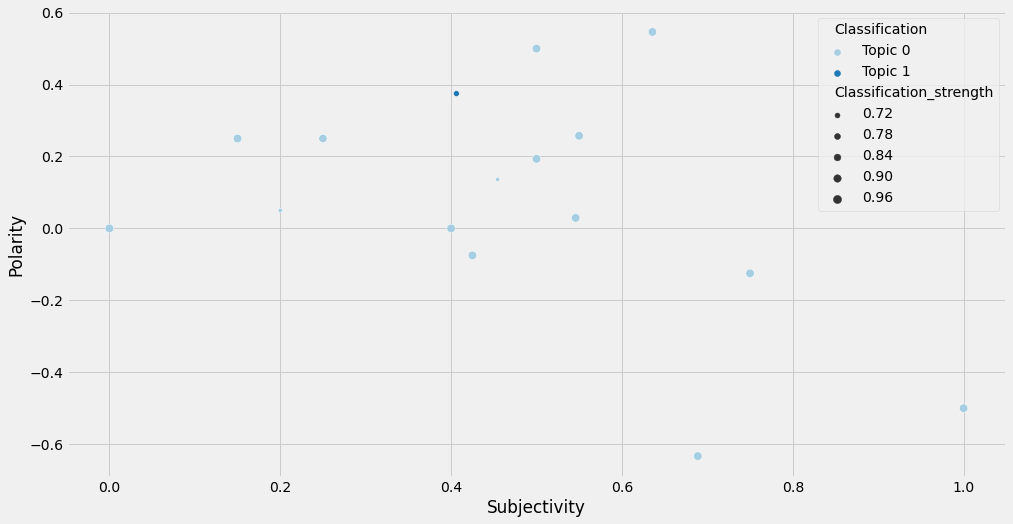

In [87]:
sns.color_palette("Paired")
plt.figure(figsize=(15,8))

ax = sns.scatterplot(x="Subjectivity", y="Polarity", data=df, hue="Classification", size = "Classification_strength", palette="Paired")

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")